# Book rating regression project

## 1. Introduction


[Need to write an introduction here, about the data, regression problem]

## 2. Data exploration

### Loading the data

In [1]:
import pandas as pd

In [2]:
raw_df = pd.read_csv(
    filepath_or_buffer="data/books.csv",
    on_bad_lines="warn",
    sep=",",
    skipinitialspace=True,
)

Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



We notice how some rows had too many fields. The `on_bad_lines="warn"` argument skips them for us. When we go look at those rows in the csv file, we notice that some books had comas `,` in their title or authors names.

For example for line 3350 is as follows:
```
12224,Streetcar Suburbs: The Process of Growth in Boston  1870-1900,Sam Bass Warner, Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,61,6,4/20/2004,Harvard University Press
```

The author name is contains a coma `Sam Bass Warner, Jr./Sam B. Warner`.

We will skip those lines as there are only 4 of them (out of 11127).

In [3]:
raw_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [4]:
print(f"The dataset has {raw_df.shape[1]} columns and {raw_df.shape[0]} rows.")

The dataset has 12 columns and 11123 rows.


Checking for NA values:

In [5]:
raw_df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

Great, we have no NA values. The dataset is now clean

In [6]:
df = raw_df

In [7]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


### Preliminary analysis

**Questions:**
- Is the data balanced?
- Which features are useful and which aren't?

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We will plot the distributions of the main numerical features:
- number of pages
- number of ratings
- number of reviews
- average rating

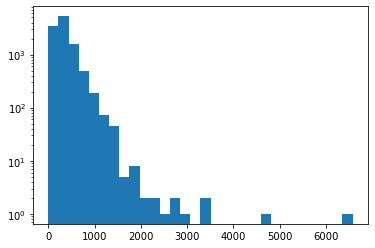

In [9]:
plt.hist(df["num_pages"], bins=30)
plt.yscale("log")
plt.show()

We observe that most books have less than 1000 pages. Under 1000 pages the distribution is overall balanced

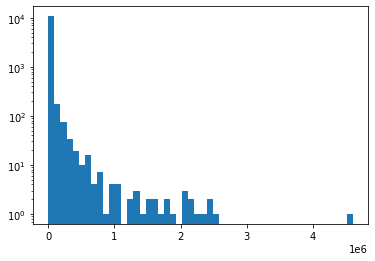

In [10]:
plt.hist(df["ratings_count"], bins=50)
plt.yscale("log")
plt.show()

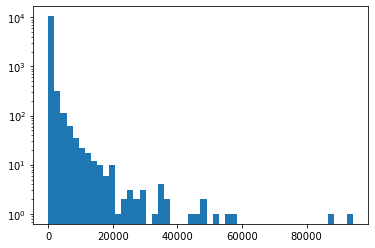

In [11]:
plt.hist(df["text_reviews_count"], bins=50)
plt.yscale("log")
plt.show()

Generally speaking, the distribution of number of ratings and reviews are skewed towards 0. This means that generally speaking, most books have fewer numbers of reviews and ratings while a few books have a lot. Such distribution resembles a [power law distribution](https://en.wikipedia.org/wiki/Power_law).

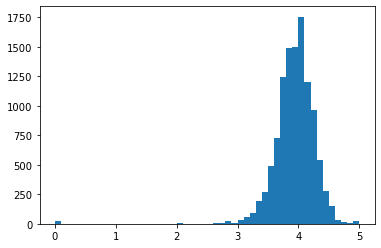

In [12]:
plt.hist(df["average_rating"], bins=50)
plt.show()

We notice immediately that the target feature `average_rating` is skewed towards an average of 4. It resembles a normal distribution centered around 4. This data is inherently imbalanced (almost all ratings between 3 and 5, almost no ratings between 0 and 3).
We will have to take this into consideration when creating the training and testing sets: these sets should both include books with a wide range of average ratings.

Computing the correlation matrix:

In [94]:
corr_matrix = df.corr(numeric_only=True)

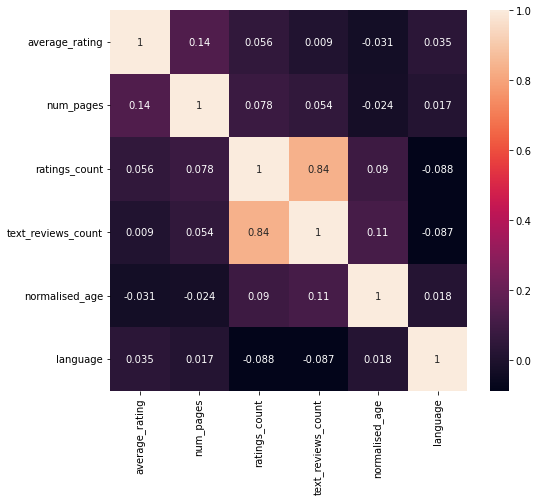

In [95]:
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

We are particularly interested in the correlations between `average_rating` and other features. We make a few observations:
- `average_rating` has no substantial correlation with `isnb13` which should be expected
- `average_rating` slighty correlates with `ratings_count` and `text_reviews_count`. Meaning that on average, books with more ratings and reviews tend to have slightly better ratings
- `average_rating` correlates positively with `num_pages` in decent amounts
- `average_rating` slighty correlates negatively with `bookID`. This has no reason to be the case and is likely just noise from the random ordering of the dataset.

### Removing unused data

We can remove the data fields we know we will not use:
- bookID
- idbn
- isbn13

In [26]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publisher', 'normalised_age'],
      dtype='object')

In [27]:
df = df.drop(["bookID", "isbn", "isbn13"], axis=1)

## 3. Feature Engineering

### Publication date

In the data, we have a publication date field, maybe the age of the book could be an interesting feature. In particular, does the age of the book have an impact on the average rating ?

To figure this out, we first need to convert dates into a numerical value that can be interpreted by a regression model. To do so, we will create a function that converts a date to number of seconds since a reference time. Then, normalise this number of seconds between 0 and 1 values. In particular, where 0 corresponds to the oldest book in our dataset, and 1 the most recently published book.


In [15]:
from datetime import datetime, MINYEAR, timedelta
from time import strptime

In [16]:
def date_to_datetime(date: str) -> datetime:
    """
    Converts date string to corresponding datetime format
    """
    try:
        new_time_format = datetime.strptime(date, "%m/%d/%Y")
        return new_time_format
    except ValueError:
        # Some dates seem to be erronous (days that do not exist for given months)
        # Correcting these days manually
        newdate = date.split("/")
        if newdate[1] == "31":
            newdate[1] = "30"
        newdate = newdate[0] + "/" + newdate[1] + "/" + newdate[2]
        return datetime.strptime(newdate, "%m/%d/%Y")

In [17]:
df["publication_date"] = df["publication_date"].apply(date_to_datetime)

In [18]:
oldest_book = min(df["publication_date"])
newest_book = max(df["publication_date"])

print(f"Oldest book published on {oldest_book}.")
print(f"Most recent book published on {newest_book}")

Oldest book published on 1900-01-01 00:00:00.
Most recent book published on 2020-03-31 00:00:00


In [19]:
def normalise_age(book_date: datetime) -> float:
    """
    Converts book date into normalised value in [0, 1] interval where 0 corresponds to the oldest book and 1 corresponds to most recent book
    """
    return (book_date.timestamp() - oldest_book.timestamp()) / (newest_book.timestamp() - oldest_book.timestamp())


def get_real_age(normalised_age: float) -> datetime:
    """
    Get back the date from a normalised age.
    """
    datetime_s = oldest_book.timestamp() + (newest_book.timestamp() - oldest_book.timestamp()) * normalised_age
    return datetime.fromtimestamp(datetime_s)


In [20]:
df["normalised_age"] = df["publication_date"].apply(normalise_age)

We have created a feature which describes the age of the book where 0 is the oldest book in the dataset (Consider the Lilies) and 1 is the most recent book (A Quick Bite (Argeneau #1))
Let's look the distribution of book age and how this feature correlates with the average_rating.

If we need to get the date back from the normalised age, we can just use the `get_real_age` function.

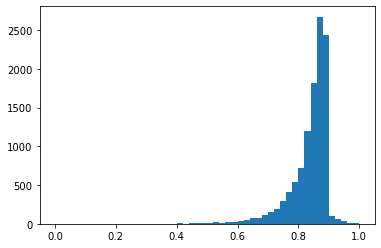

In [21]:
plt.hist(df["normalised_age"], bins=50)
plt.show()

In [22]:
print(f"Most books have been published between {get_real_age(0.8)} and {get_real_age(0.9)}")

Most books have been published between 1996-03-13 05:48:00 and 2008-03-22 03:24:00


We see that the age distribution isn't balanced. most books from the dataset have been published between the years 1990 and 2010.

Plotting the correlation matrix with the newly created columns:

/tmp/ipykernel_31597/2933625568.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


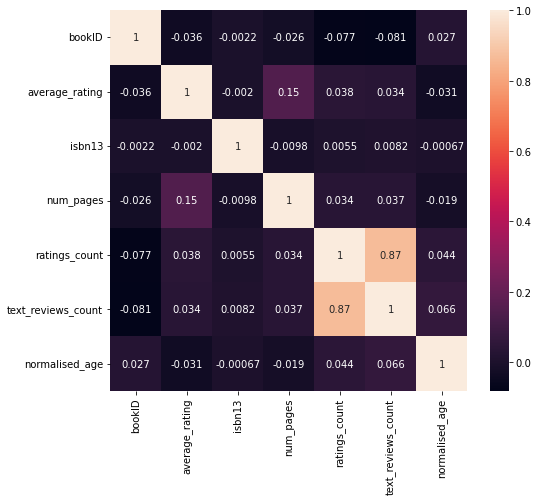

In [23]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [24]:
print("Correlation between average_rating and age:", round(corr_matrix["average_rating"]["normalised_age"], 3))

Correlation between average_rating and age: -0.031


The `normalised_age` slightly anticorrelates with the average rating. This means that on average, older books have slightly better ratings than more modern books.

In [25]:
df = df.drop("publication_date", axis=1)

We need to figure out which features can be use to predict the `average_rating`. The easy and obvious features are `nb_ratings`, `nb_reviews` and `nb_pages`. What about the book age ? Or the language ? Can we use this data to actually predict the average rating ?

### Language


In [28]:
unique_languages = list(df["language_code"].unique())
print(unique_languages)

['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm', 'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale']


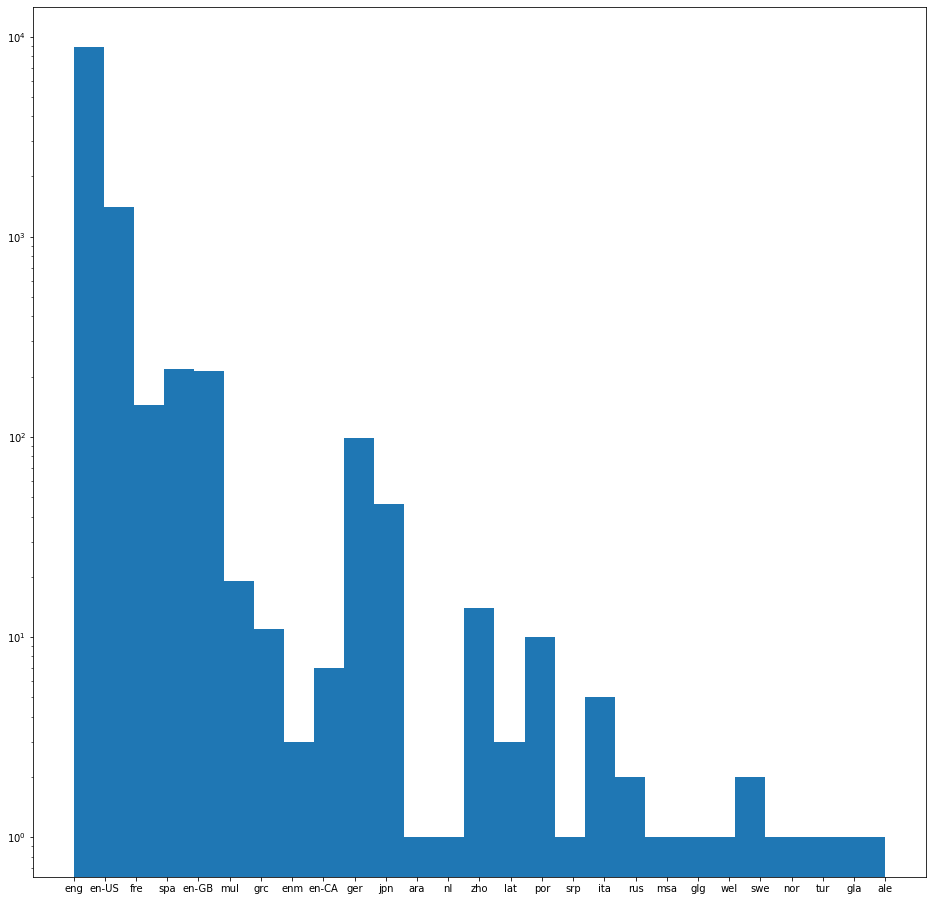

In [29]:
plt.figure(figsize=(16, 16))
plt.hist(df["language_code"], bins=len(unique_languages))
plt.yscale("log")

We notice that most books are written in english. We can maybe make a split "english" / "foreign" ? In addition, we would like to have only numerical values, thus separating it into a binary values (0 for english and 1 for foreign)

In [30]:
def sort_english(language_code: str) -> int:
    """
    Returns 0 if the language code corresponds to english, 1 otherwise.
    """
    if language_code in ['eng', 'en-US', 'en-GB', 'en-CA', "enm"]:
        return 0
    else:
        return 1

In [31]:
df["language"] = df["language_code"].apply(sort_english)

In [32]:
nb_foreign = df[df["language"] == 1].shape[0]
print(f"There are {nb_foreign} foreign books ({round(100 * nb_foreign / df.shape[0], 3)} %)")

There are 583 foreign books (5.241 %)


In [33]:
# Removing original language code data from dataframe 
df = df.drop("language_code", axis=1)

### Title, publisher and author data

Can we use the data containing the author and publisher names and titles ? First let's see how many different authors, publishers and titles we have

In [34]:
tot_publisher = len(df["publisher"].unique())
tot_authors = len(df["publisher"].unique())
tot_titles = len(df["title"].unique())

In [35]:
print(f"There is a total of {tot_authors} authors")
print(f"There is a total of {tot_publisher} publishers")
print(f"There is a total of {tot_titles} titles")

There is a total of 2290 authors
There is a total of 2290 publishers
There is a total of 10348 titles


If we wanted to use this data as features, we would have to convert it to numerical values. There is no practical way to convert tousands of names into quantifiable metrics. Thus, we will not use the titles and publisher and author names in our modeling

In [36]:
# Removing titles, authors and publishers from the dataframe
df = df.drop(["authors", "publisher", "title"], axis=1)

In [37]:
df.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'normalised_age', 'language'],
      dtype='object')

### Outliers

[Decrire la procedure de suppression d'outliers]

In [38]:
df_no_outliers = df.copy()

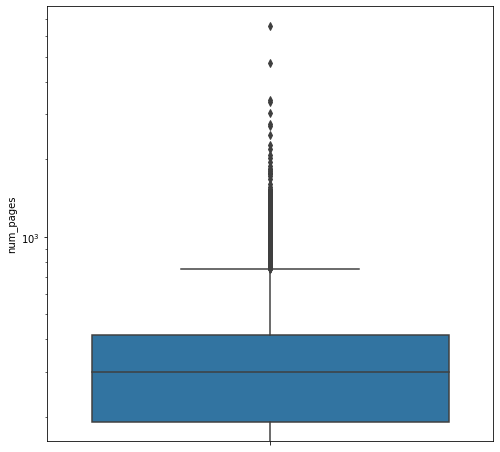

In [39]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df["num_pages"])
plt.yscale("log")
plt.show()

In [40]:
df[df["num_pages"] > 2e3].shape[0]

12

In [41]:
df_no_outliers = df_no_outliers[df_no_outliers["num_pages"] < 2e3]

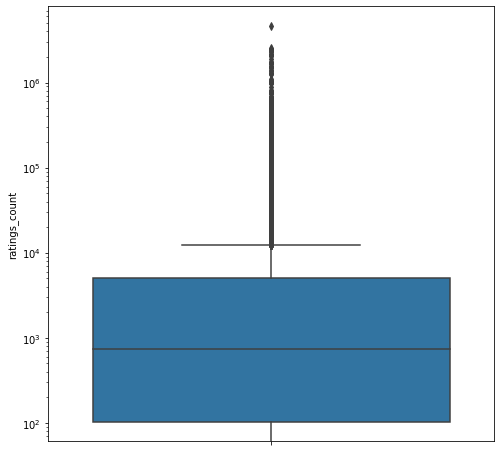

In [42]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df['ratings_count'])
plt.yscale("log")
plt.show()

In [43]:
df[df["ratings_count"] > 1e5].shape[0]

352

In [44]:
df_no_outliers = df_no_outliers[df_no_outliers["ratings_count"] < 1e5]

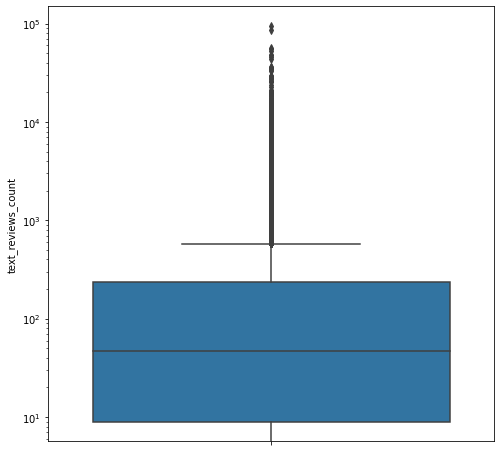

In [45]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df["text_reviews_count"])
plt.yscale("log")
plt.show()

In [46]:
df[df["text_reviews_count"] > 1e4].shape[0]

94

In [47]:
df_no_outliers = df_no_outliers[df_no_outliers["text_reviews_count"] < 1e4]

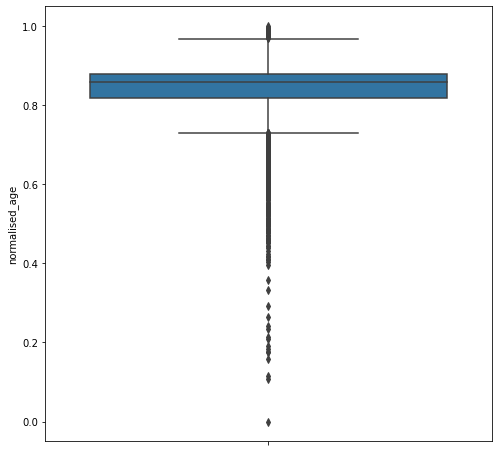

In [48]:
plt.figure(figsize=(8, 8))
sns.boxplot(y=df['normalised_age'])
plt.show()

In [49]:
df[df["normalised_age"] < 0.5].shape[0]

52

In [50]:
df_no_outliers = df_no_outliers[df_no_outliers["normalised_age"] > 0.5]

In [51]:
# Making the dataframe without outliers the default dataframe
df_with_outliers = df.copy()
df = df_no_outliers

In [52]:
print(f"We have kept {df.shape[0]} rows of data ({round(100 * df.shape[0] / df_with_outliers.shape[0], 2)} %)")

We have kept 10708 rows of data (96.27 %)


After removing outliers, we have a total of 10708 rows, which is enough to do substantial machine learning modeling

In [53]:
df.head()

,average_rating,num_pages,ratings_count,text_reviews_count,normalised_age,language
2,4.42,352,6333,244,0.863499,0
5,3.74,152,19,1,0.875840,0
7,4.38,815,3628,254,0.880143,0
9,4.22,215,4930,460,0.869783,0
10,4.22,6,1266,253,0.875065,0


### Conclusion

We have kept the following features:
- average_rating (target feature)
- num_pages
- ratings_count
- text_reviews_count
- normalised_age
- language

## 4. Data modeling 

In order to predict the `average_rating`, we're going to split our dataset in two to have a first trainning set and a second test set. We'll also divide our data in two: on the one hand, the explanatory variables: 

- `num_pages`
- `ratings_count`
- `text_reviews_count`
- `normalised_age`
- `language`

and on the other hand, the variable to be predicted: `average_rating`

### Splitting the data:

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

Giving 20% for test and 80% for training

In [55]:
df_train, df_test =  train_test_split(df, test_size = 0.2, random_state=42)

In [56]:
print(len(df))
print(len(df_test))
print(len(df_train))

10708
2142
8566


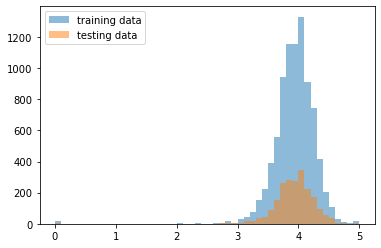

In [57]:
plt.hist(df_train["average_rating"], bins=50, label="training data", alpha=0.5)
plt.hist(df_test["average_rating"], bins=50, label="testing data", alpha=0.5)
plt.legend()
plt.show()

Plotting the histogram of the training and testing data, we observe that both resemble the original distribution. By design we have less testing data than training data.

In [58]:
# get the values of the explanatory variables for the training data
X_train = df_train.loc[:,['num_pages', 'ratings_count', 'text_reviews_count', 'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_train = df_train.average_rating.values

# get the values of the explanatory variables  for the test data
X_test = df_test.loc[:,['num_pages', 'ratings_count', 'text_reviews_count', 'normalised_age', 'language']].values
#the values of the variable to be predicted 
y_test = df_test.average_rating.values

In [59]:
df_test.average_rating.values

array([4.32, 4.18, 3.75, ..., 4.08, 3.44, 4.08])

### How to evaluate a model

Before training the model, it is useful to consider how we will evaluate our models. For a regression model, the most common metrics are the Root-Mean-Square Error (RMSE) and the coefficient of determination (R-square or R²). In more details:

- [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) measures the square root of the average of squared errors, where the error corresponds to the difference in absolute value between the true and the predicited values. It is always positive and the lower it is, the better the model is at fitting the data. In an ideal case the RMSE would be equal to 0. The formula for the RMSE is as follow:

$ \text{RMSE} = \sqrt{\frac{\sum_i^N{(y_i^{true} - y_i^{pred})^2}}{N}} $

- [R-square](https://en.wikipedia.org/wiki/Coefficient_of_determination) measures the proportion of the variation in the dependent variable that is predictable from the independent variable. In other words, it indicates how well the predicted data approximate the real data. The R-squared value should be between 0 and 1 with 1 indicating the predicted data perfectly fits the real data. A negative R-square indicates that the model predicts the data worse than a naive linear model with no input features (i.e. that always predits the mean value of the data).

It can also be useful to look at the max error, i.e. what is the worst performing prediction.

To help compare different models, we have created a function `evaluate_model` that takes the real and the predicted ratings and does the following:
- plots a barplot comparing the prediction of the 20 first books in our test dataframe with the true values
- plots scatterplot of the predicted ratings as a function of the true ratings
- compute, prints and returns the following metrics:
    - RMSE
    - R² score
    - the max error

In [60]:
from sklearn.metrics import max_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
from typing import List, Dict


all_evaluations = pd.DataFrame(columns=["RMSE", "r2_score", "max_error"])


def evaluate_model(
    y_true : List[float],
    y_predict: List[float],
    model_name: str = "",
    model_parameters: str = "",
    include_plots: bool = True
    ) -> Dict[str, float]:
    """
    Computes regression metrics for given predicted values y_predict to compared true values y_true.
    If include_plots, plots a barplot to compare a sample of ratings and a scatterplot comparing real and predicted values
    """
    
    print(f"Evaluating {model_name} model", end=" ")
    if model_parameters != "":
        print(f"with parameters :\n{model_parameters}")
    
    if include_plots:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        ax1.bar([x for x in range(20)], y_predict[: 20], width=(1 / 3), label="Predicted ratings")
        ax1.bar([x - 1 / 3 for x in range(20)], y_true[: 20], width=(1 / 3), label="True ratings")
        ax1.set_ylim([0, 5])
        ax1.set_title("Barplots comparing the rating predictions of the first 20 books")
        ax1.set_ylabel("Average ratings")
        ax1.legend()
        
        ax2.plot(y_true, y_predict, ls="", marker="x", ms=2)
        ax2.plot([0, 5],[0, 5], alpha=0.5)
        ax2.set_xlabel("Real ratings")
        ax2.set_ylabel("Predicted ratings")
        ax2.set_xlim([0, 5])
        ax2.set_ylim([0, 5])
        ax2.set_title("Scatterplot showing the distribution of the\npredicted ratings with respect to the true ratings")
        
        #fig.tight_layout()
        plt.show()

    evaluation = dict()
    
    evaluation["RMSE"] = mean_squared_error(y_true, y_predict, squared=False)
    evaluation["r2_score"] = r2_score(y_true, y_predict)
    evaluation["max_error"] = max_error(y_true, y_predict)

    for key in evaluation.keys():
        print(f"{key} : {round(evaluation[key], 3)}")
    
    return evaluation

We will try out the following models:
- Linear regression
- Random Forest
- Decision Tree
- Support Vector Regression
- Gradient Boosting
- Adaboost
- StackingCV

### Linear Regression

Before trying out complicated models it is usually useful to test simple linear regression models. This allows us to evaluate the strength of the relationship between the predictor variables and the target variable, as well as creating a baseline model to compare subsequent models to.

We will be using the scikit-learn implementation of the [Linear Regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).

In [61]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
LR_predict = LR_model.predict(X_test)

Evaluating LinearRegression model 

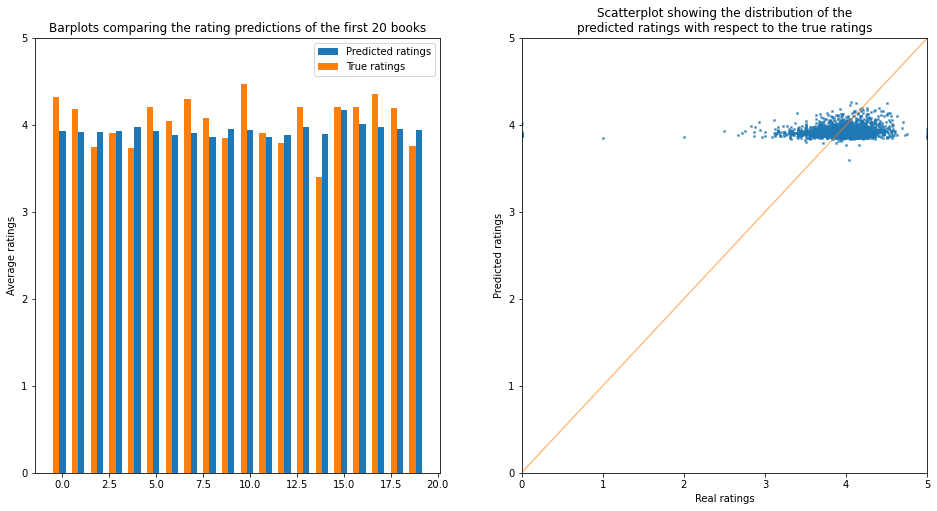

RMSE : 0.381
r2_score : 0.022
max_error : 4.027


In [62]:
LR_eval = evaluate_model(y_test, LR_predict, "LinearRegression")

all_evaluations.loc["Linear Regression"] = LR_eval.values()

The results of the model seem to indicate moderate performance. 
The RMSE  and the MAE metrics are relatively low, which is positive but it's important to note that the model is always predicting notes around `3.8` and `4.2`.This could be explain by the stucture of our dataset...

As we have seen before, the `average_rating` is mostly of the time around `4`.

Additionally, the max error of `4.025` suggests that the model is making some fairly large errors on certain predictions.

However, the coefficient of determination r2 of `0.03`and explained variance score of `0.031` indicate that the model is not able to explain much of the variance in the target variable data.

This suggests that the model isn't able to capture important relationships between the independent variables and the dependent variable. Overall, it may be necessary to explore alternative modeling techniques or adjust the parameters of the existing model to improve its performance.

### Random Forest

Next we will try out a model of the essemble family: a random forest regressor model. It works by creating `n_estimators` models called trees which will be trained on slightly different subsets of the training data. Once all trees (models) have been trained, their predictions are averaged to provide a final result. This averaging step is what we call ensemble learning.

We will be using the scikit-learn implementation of the [Random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).


In [63]:
from sklearn.ensemble import RandomForestRegressor 

# Crating and training a random forest regressor
RF_model = RandomForestRegressor(
    n_estimators=100,
)
RF_model.fit(X_train, y_train)
RF_predict = RF_model.predict(X_test)

Evaluating Random Forest model with parameters :
n_predictors: 100
5 features


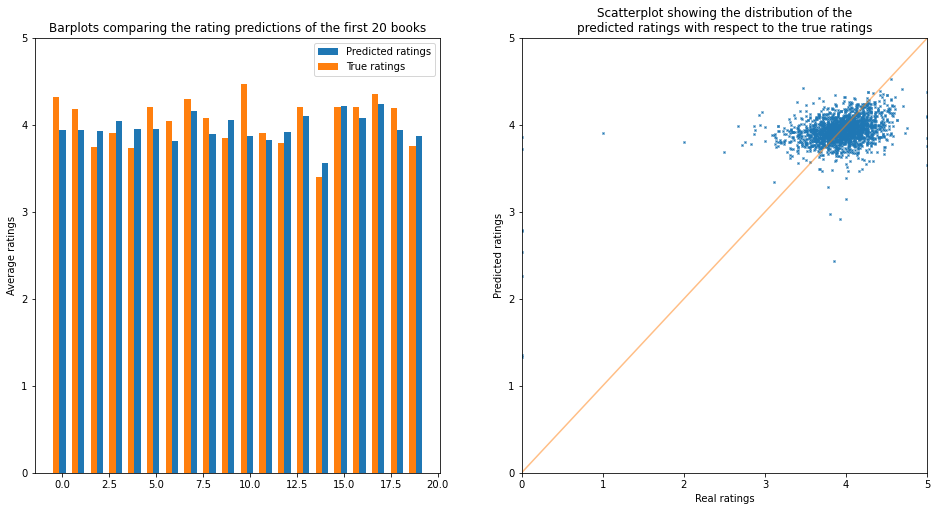

RMSE : 0.339
r2_score : 0.225
max_error : 3.86


In [64]:
RF_eval = evaluate_model(y_test, RF_predict, "Random Forest", "n_predictors: 100\n5 features")

all_evaluations.loc["Random Forest"] = RF_eval.values()

[Talk about the results briefly]

### Decision Tree Regressor

[Explications sur decision tree regressor ici]

In [65]:
from sklearn.tree import DecisionTreeRegressor

# Create the decision tree regressor model
DT_model = DecisionTreeRegressor(max_depth=3, random_state=42)

# Train the model on the training data
DT_model.fit(X_train, y_train)

DT_pred = DT_model.predict(X_test)

Evaluating Decision Tree Regressor model 

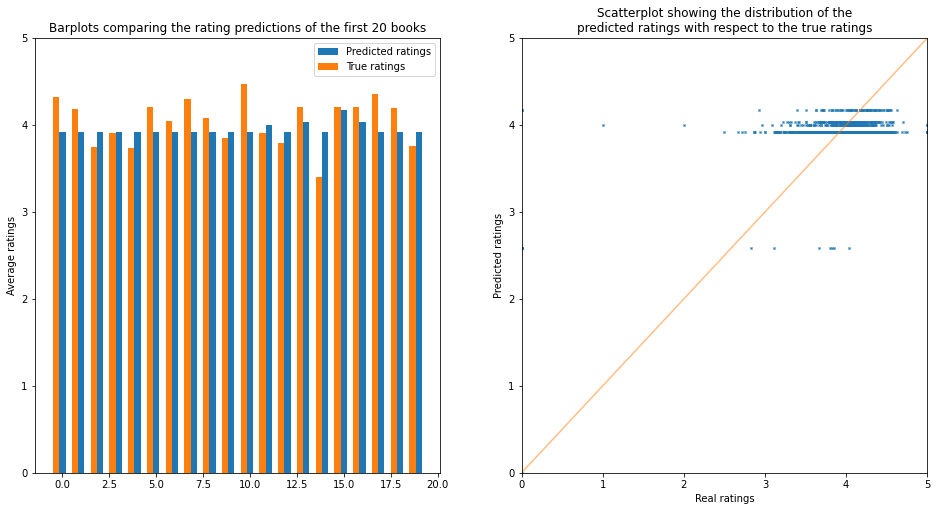

RMSE : 0.351
r2_score : 0.17
max_error : 4.167


In [66]:
DT_eval = evaluate_model(y_test, DT_pred, "Decision Tree Regressor")

all_evaluations.loc["Decision Tree"] = DT_eval.values()

[Talk about the results briefly]

### Support Vector Regression (SVR) with Radial Basis Function (RBF) kernel

The next model we will see uses a technique called support vector machines. It consists in transforming the input data using a kernel function which will increase the dimensionality of the data. In this higher dimension, the data points can be more easily separated using a hyperplane. The SRV model is trained by finding the best hyperplane such that it maximises the distances between the hyperplane and the data points. Once the optimal hyperplane is found, it can be used to compute predictions.

We will use the scikit-learn implementation of [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

In [67]:
from sklearn.svm import SVR

In [68]:
params = {
    "kernel": "rbf",
    "gamma": "auto"
}


SVR_model = SVR(**params)

SVR_model.fit(X_train, y_train)
SVR_predict = SVR_model.predict(X_test)

Evaluating SVR regression model with parameters :
parameters = {'kernel': 'rbf', 'gamma': 'auto'}


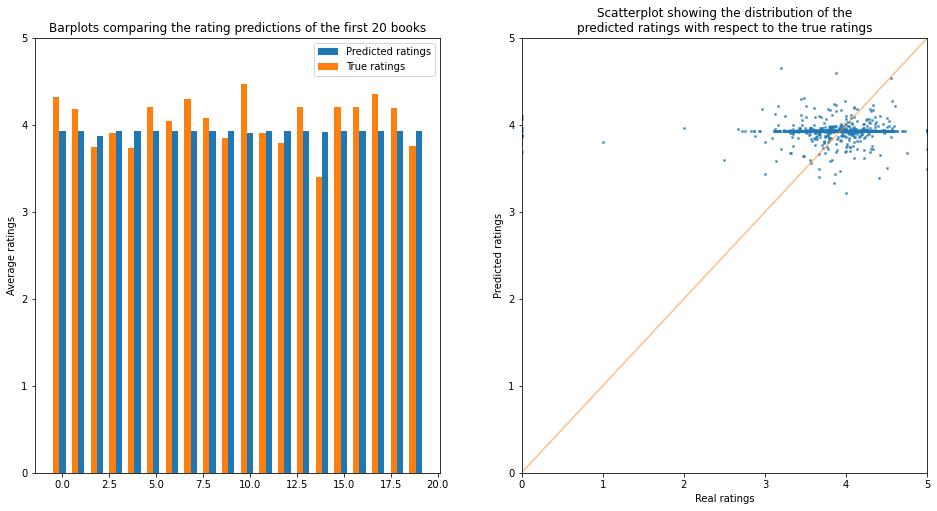

RMSE : 0.389
r2_score : -0.021
max_error : 4.104


In [69]:
SVR_eval = evaluate_model(y_test, SVR_predict, "SVR regression", f"parameters = {params}")

all_evaluations.loc["SVR"] = SVR_eval.values()

[Talk about the results briefly]

### Gradient Boosting

The next model we will try out is called Gradient Boosting. It also is an ensemble model. It works by combining multiple decision trees with each new tree built trained to correct the erros made by the previous trees. Once a given number of trees are trained, in order to make a prediciton, the final model takes the average prediction of each tree.

In the following section, we will be using the scikit-learn implementation: [Gradient boosting regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

In [71]:
params = {
    "alpha": 0.7, 
}


GB_model = GradientBoostingRegressor(**params)

GB_model.fit(X_train, y_train)
GB_predict = GB_model.predict(X_test)

Evaluating Gradient Boosting model with parameters :
parameters = {'alpha': 0.7}


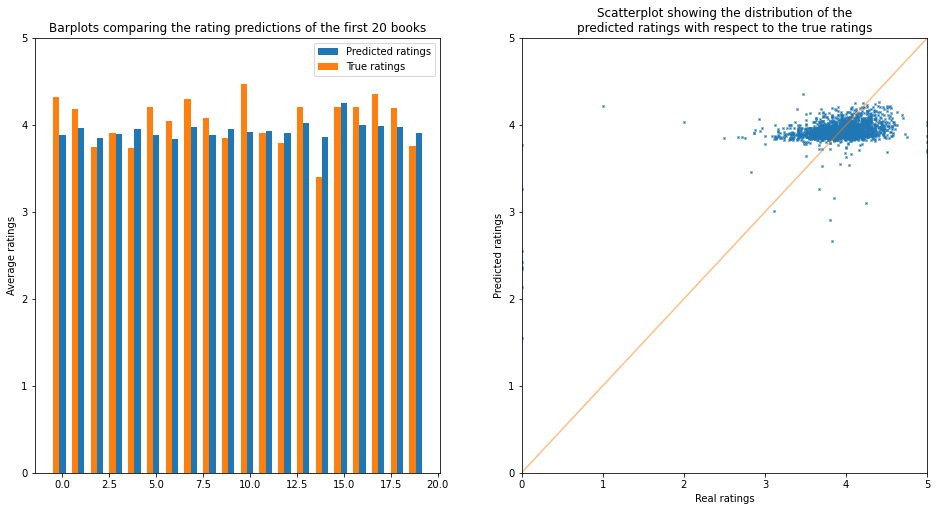

RMSE : 0.334
r2_score : 0.246
max_error : 3.772


In [72]:
GB_eval = evaluate_model(y_test, GB_predict, "Gradient Boosting", f"parameters = {params}")

all_evaluations.loc["Gradient Boosting"] = GB_eval.values()

[Talk about the results briefly]

### Adaboost

AdaBoost, short for Adaptive Boosting, is a machine learning algorithm that combines several weak or simple classifiers to form a strong or more accurate classifier.

In AdaBoost, each weak classifier is trained on a subset of the training data, and the algorithm assigns higher weights to misclassified samples, making them more important in the next iteration. The weights of the misclassified samples are adjusted iteratively, and the final classification model is a weighted combination of all the weak classifiers, with the weights determined by their overall accuracy.

The algorithm is flexible and can work with various types of weak classifiers, such as decision trees, logistic regression, and neural networks. AdaBoost is also popular because it can handle imbalanced data and reduce the risk of overfitting.

Overall, AdaBoost is a powerful and widely used ensemble learning method that can improve the performance of machine learning models in a variety of applications.

In [73]:
from sklearn.ensemble import AdaBoostRegressor

In [74]:
# We will reuse the previously trained Linear Regression and Decision Tree models
# to construct the adaboost model

# Create the AdaBoost model using decision trees as the base estimator
ADA_DT = AdaBoostRegressor(estimator=DT_model, n_estimators=50, learning_rate=1.0, random_state=42)
ADA_DT.fit(X_train, y_train)

# Create the AdaBoost model using linear regression as the base estimator
ADA_LR = AdaBoostRegressor(estimator=LR_model, n_estimators=50, learning_rate=1.0, random_state=42)
ADA_LR.fit(X_train, y_train)

# Make predictions on the test set
ADA_DT_pred = ADA_DT.predict(X_test)
ADA_LR_pred = ADA_LR.predict(X_test)


Evaluating Adaboost with Decision trees model 

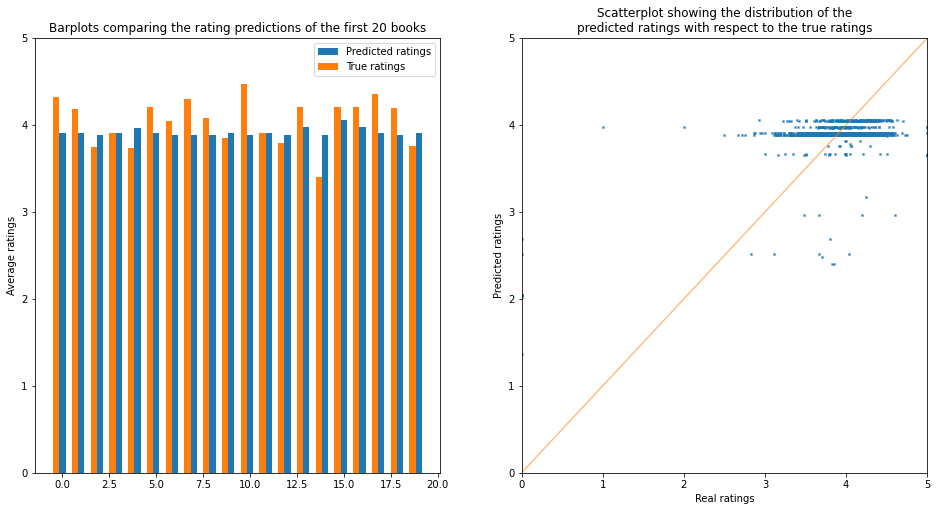

RMSE : 0.336
r2_score : 0.236
max_error : 2.972


In [75]:
ADA_DT_eval = evaluate_model(y_test, ADA_DT_pred, "Adaboost with Decision trees")

all_evaluations.loc["Adaboost Decision Tree"] = ADA_DT_eval.values()

Evaluating Adaboost with Linear Regression model 

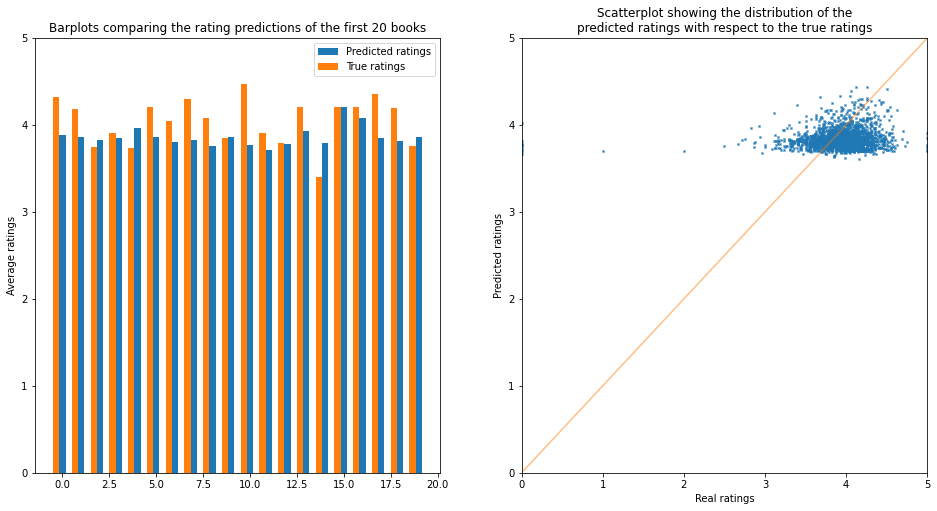

RMSE : 0.397
r2_score : -0.061
max_error : 4.027


In [76]:
ADA_LR_eval = evaluate_model(y_test, ADA_LR_pred, "Adaboost with Linear Regression")

all_evaluations.loc["Adaboost Linear Regression"] = ADA_LR_eval.values()

[Talk about the results briefly]

### Stacking

The stacking model (or stacking) is a machine learning technique that combines multiple base models to produce a more accurate final 
prediction. The method involves training multiple base models on the training set, and then using these models to predict outputs on the validation set. The predicted outputs from these base models are then used as inputs for a higher-level model, called a "meta-model", which produces the final prediction.

We've decided to use this model because we have poor predictive performance with single models, this model allows us to combine the outputs of multiple models trained on the same dataset,so it can improve the accuracy of the final prediction. 

As we have seen, the `gradient boost model` is the most effective in our case, so we will use it as the meta model.  

In [77]:
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.regressor import StackingCVRegressor

In [78]:
model1 = RandomForestRegressor(n_estimators=10, random_state=42)
model2 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model3 = LinearRegression()
model4 = KNeighborsRegressor(n_neighbors=5)

In [79]:
meta_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [80]:
stack = StackingCVRegressor(
#    regressors=(model1, model2, model3, model4),
    regressors=(DT_model, RF_model, GB_model),
    meta_regressor=meta_model,
    cv=5,
    shuffle=True,
    random_state=42,
)

stack.fit(X_train, y_train)
stack_predict = stack.predict(X_test)

Evaluating Stack model 

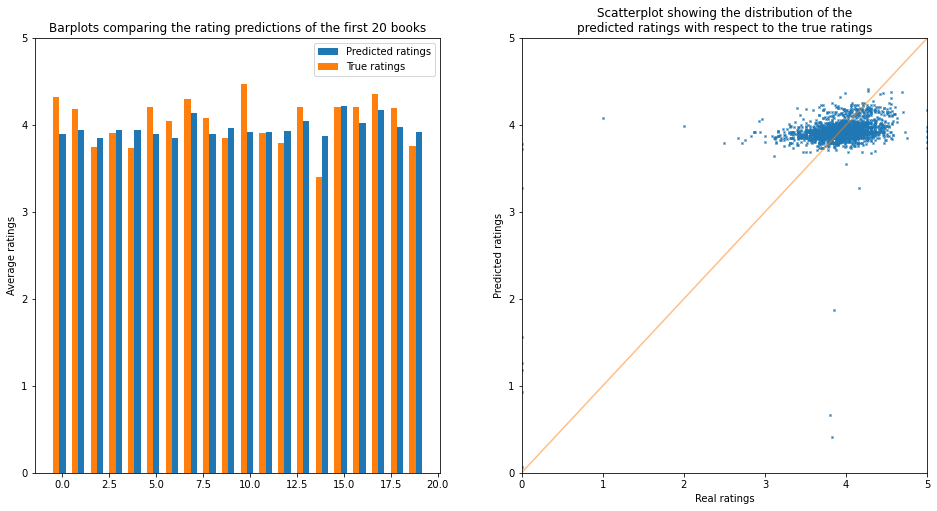

RMSE : 0.339
r2_score : 0.222
max_error : 3.785


In [81]:
stack_eval = evaluate_model(y_test, stack_predict, "Stack")

all_evaluations.loc["Stacking model"] = stack_eval.values()

[Talk about the results, in particular, this is a great score]

## 5. Comparing the models

### Modeling score comparison

In this section We will compare the performance of different models.

In [82]:
print("The evaluations of each model we have tried:")
all_evaluations

The evaluations of each model we have tried:


,RMSE,r2_score,max_error
Linear Regression,0.380635,0.022195,4.027173
Random Forest,0.338862,0.225036,3.859600
Decision Tree,0.350664,0.170115,4.166667
SVR,0.388870,-0.020573,4.104140
Gradient Boosting,0.334190,0.246259,3.772111
Adaboost Decision Tree,0.336492,0.235840,2.972105
Adaboost Linear Regression,0.396550,-0.061286,4.027236
Stacking model,0.339450,0.222346,3.784602


In [83]:
all_evaluations = all_evaluations.sort_values(["r2_score", "RMSE"], ascending=[False, True])

print("Evaluations sorted by R2_score:")
all_evaluations

Evaluations sorted by R2_score:


,RMSE,r2_score,max_error
Gradient Boosting,0.334190,0.246259,3.772111
Adaboost Decision Tree,0.336492,0.235840,2.972105
Random Forest,0.338862,0.225036,3.859600
Stacking model,0.339450,0.222346,3.784602
Decision Tree,0.350664,0.170115,4.166667
Linear Regression,0.380635,0.022195,4.027173
SVR,0.388870,-0.020573,4.104140
Adaboost Linear Regression,0.396550,-0.061286,4.027236


First of all, we observe that the R2_score and RMSE go hand in hand. Generally speaking, the better (higher) the R2_score is, the better (lower) the RMSE is. This indicates that these metrics are at least coherent between each other.
We also note that the RMSE scores are relatively similar to each other while the R2_score presents much more diverse values.

The best performing model in terms of R2_score and RMSE is the Gradient Boosting model.

If one were to prefer minimising the maximal error however, then the The Adaboost Decision Tree model performs the best. As in, its worst mistakes are less wrong compared to the generally better performing models like Gradient Boosting and Random Forest.

### Comparing model with all features vs less features

We have trained and evaluated our models using all the features we have created. This is from the belief that the more information the model has, the more opportunities it has to learn fine distinctions between these books.

To test this hypothesis, we can compare our best performing model, Gradient Boosting, with all or only some of the features we have created (num_pages, ratings_count, text_reviews_count).

Evaluating Gradient Boosting model with parameters :
parameters = {'alpha': 0.7}


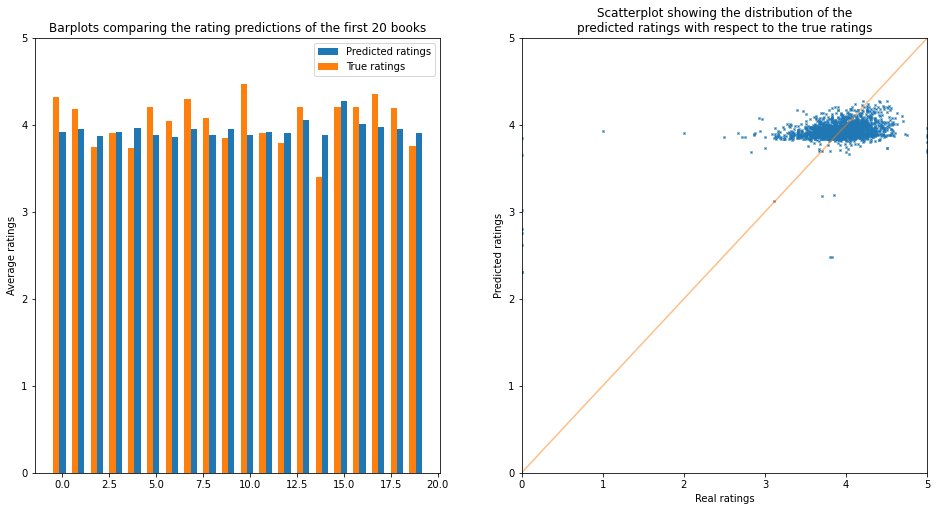

RMSE : 0.345
r2_score : 0.197
max_error : 3.854


In [84]:
# Using only num_pages, ratings_count and text_reviews_count
X_train_3features = df_train.loc[:, ['num_pages', 'ratings_count', 'text_reviews_count']].values

y_train_3features = df_train.average_rating.values

X_test_3features = df_test.loc[:,['num_pages', 'ratings_count', 'text_reviews_count']].values
y_test_3features = df_test.average_rating.values

params = {
    "alpha": 0.7, 
}


GB_model_3features = GradientBoostingRegressor(**params)

GB_model_3features.fit(X_train_3features, y_train_3features)
GB_predict_3features = GB_model_3features.predict(X_test_3features)

GB_eval_3features = evaluate_model(y_test, GB_predict_3features, "Gradient Boosting", f"parameters = {params}")

The model trained with less features performs worse than the model trained on all features on all metrics:

In [85]:
print("            3 features | all features:")
print(f"RMSE      :      {round(GB_eval_3features['RMSE'], 3)} > {round(GB_eval['RMSE'], 3)}")
print(f"R2_score  :      {round(GB_eval_3features['r2_score'], 3)} < {round(GB_eval['r2_score'], 3)}")
print(f"max_error :      {round(GB_eval_3features['max_error'], 3)} > {round(GB_eval['max_error'], 3)}")

            3 features | all features:
RMSE      :      0.345 > 0.334
R2_score  :      0.197 < 0.246
max_error :      3.854 > 3.772


This confirms our intuition saying that giving the model more information allows it to make better predictions. In particular, the publication age and the language of the book provide an actual information on the average rating of the book.

### Comparing with and without outliers

We have trained and evaluated the models with outliers removed. It is interesting to see how much worse our model would perform if we hadn't removed the outliers. We will again use the Gradient Boosting model, with all 5 features.

In [86]:
# Creating a train_test split with outliers 
df_train_outliers, df_test_outliers =  train_test_split(df_with_outliers, test_size = 0.2, random_state=42)

X_train_outliers = df_train_outliers.loc[:, ['num_pages', 'ratings_count', 'text_reviews_count', 'normalised_age', 'language']].values
y_train_outliers = df_train_outliers.average_rating.values

X_test_outliers = df_test_outliers.loc[:,['num_pages', 'ratings_count', 'text_reviews_count', 'normalised_age', 'language']].values
y_test_outliers = df_test_outliers.average_rating.values

First, we will try our previously trained model (GB_model) trained without the outliers on the data with the outliers.

Evaluating Gradient Boosting model with parameters :
parameters = {'alpha': 0.7}


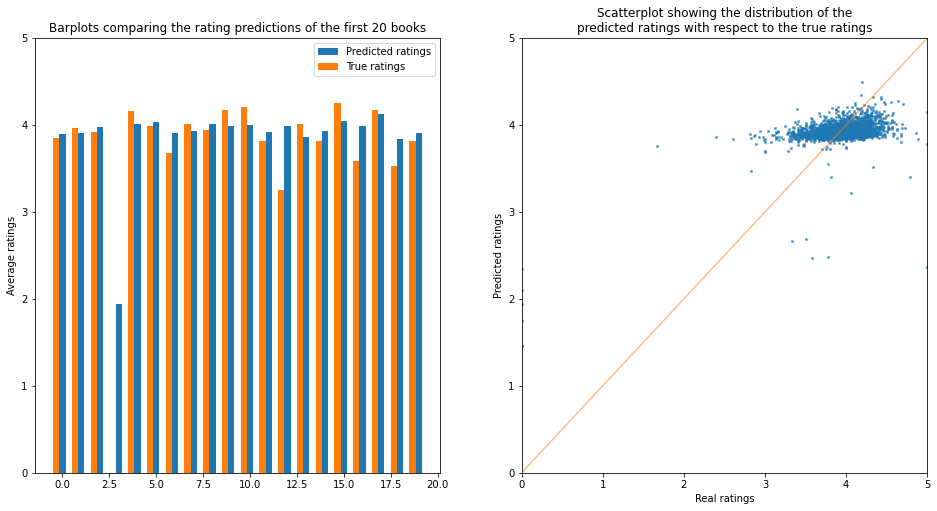

RMSE : 0.297
r2_score : 0.303
max_error : 2.633


In [92]:
GB_predict_on_outliers = GB_model.predict(X_test_outliers)

GB_eval_on_outliers = evaluate_model(y_test_outliers, GB_predict_on_outliers, "Gradient Boosting", f"parameters = {params}",)

Surprisingly, the model trained without the outliers performs better (on all metrics) when tested on data with outliers than when tested on data without outliers.

Hypothesis 1: this could be a indicative that the model has learned really specific nuances about the data (i.e. it performs well on newly seen data: the outliers).

Hypothesis 2: It could also mean that the new train-test split presented in the testing set, data that our previously trained model has already seen in its training set. In other words, because we have tested the model on a different train-test split, it might be tested on some previoulsy seen data.

We tried to mitigate that by using the same seed in the train-test split, but the split couldn't have been identical as the input data was different to begin with.

We will now train and test the same model on the whole data with the outliers:

Evaluating Gradient Boosting model with parameters :
parameters = {'alpha': 0.7}


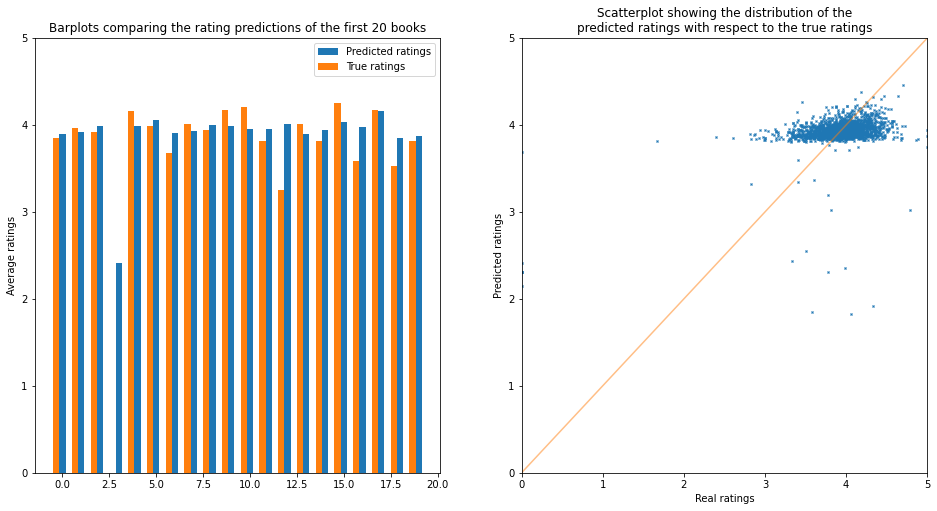

RMSE : 0.324
r2_score : 0.17
max_error : 3.685


In [93]:
params = {
    "alpha": 0.7, 
}

GB_model_with_outliers = GradientBoostingRegressor(**params)

GB_model_with_outliers.fit(X_train_outliers, y_train_outliers)
GB_predict_with_outliers = GB_model_with_outliers.predict(X_test_outliers)

GB_eval_with_outliers = evaluate_model(y_test_outliers, GB_predict_with_outliers, "Gradient Boosting", f"parameters = {params}",)

We see that when the same model is trained on the whole data (with outliers) and then tested on the outlier data, then it performs worse than the previous models (Gradient boosting tested with and without outliers). This is indicative that we might be in the hypothesis 2 scenario.

In conclusion, the removal of outliers makes the training and evaluation of model easier (better performances) but might make the models less generalisable and worse performing in real case scenarios.

Whether or not we should train the model on the data with or without outliers boils down to whether the outlier data we removed is a statistical anomaly or actually representative of book characteristics.

For instance, if we want a prediction model for future book releases it might be pertinant to remove older books from the dataset.

### Fine tuning parameters

[Take the best model, and fine tune its hyper-parameters to get the best predictor] (optional)

## 6. Conclusion

Write a conclusion, including:
- What we did (cleaning, feature engineering, modeling)
- What results we obtained at the end
- Comment and criticise the result. Discuss the limits.
- Open with what we could have done with more time and ressources (SMOTE data augmentation because of imbalanced data, enriched data by joining new data (using ISBN), exploiting the droped features using NLP for book titles)